# Infinite Data Stream

In [9]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate();

  Activating project at `~/.julia/dev/RxInfer/examples`


In [10]:
using RxInfer, Plots

┌ Info: Precompiling RxInfer [86711068-29c9-4ff7-b620-ae75d7495b3d]
└ @ Base loading.jl:1662
  ** incremental compilation may be fatally broken for this module **



We assume that we don't know the shape of our signal in advance. So we try to fit a simple gaussian random walk with unknown observation noise:

In [11]:
mutable struct DataGenerationProcess
    previous :: Float64
    process_noise :: Float64
    observation_noise :: Float64
    history :: Vector{Float64}
    observations :: Vector{Float64}
end

function getnext!(process::DataGenerationProcess)
    process.previous = process.previous + 1.0
    next = 10sin(0.1 * process.previous)
    observation = next + rand(Normal(0.0, process.observation_noise))
    push!(process.history, next)
    push!(process.observations, observation)
    return observation
end

function gethistory(process::DataGenerationProcess)
    return process.history
end

function getobservations(process::DataGenerationProcess)
    return process.observations
end

getobservations (generic function with 1 method)

In [12]:
@model function kalman_filter()
    
    # Reactive inputs
    x_t_min_mean = datavar(Float64)
    x_t_min_var  = datavar(Float64)
    τ_shape = datavar(Float64)
    τ_rate  = datavar(Float64)

    τ ~ Gamma(shape = τ_shape, rate = τ_rate)
    
    x_t_min ~ Normal(mean = x_t_min_mean, variance = x_t_min_var)
    x_t     ~ Normal(mean = x_t_min, precision = 1.0)
    
    y = datavar(Float64)
    y ~ Normal(mean = x_t, precision = τ)
    
end


@constraints function filter_constraints()
    q(x_t, τ) = q(x_t)q(τ)
end

filter_constraints (generic function with 1 method)

In [13]:
# We force stop after n data points
n = 1_000

1000

In [14]:
process = DataGenerationProcess(0.0, 1.0, 10.0, Float64[], Float64[])
# stream = timer(100, 100) |> map_to(process) |> map(Float64, getnext!) |> take(n)
stream = from(1:n) |> map_to(process) |> map(Float64, getnext!)

keystream = stream |> map(NamedTuple{(:y,), Tuple{Float64}}, (d) -> (y = d, ))

static = keep(eltype(keystream))
subscribe!(keystream, static)
static = collect(static);

In [28]:
function testme(datastream)
    autoupdates = @autoupdates begin 
        x_t_min_mean, x_t_min_var = mean_var(q(x_t))
        τ_shape = shape(q(τ))
        τ_rate = rate(q(τ))
    end
    
    engine = rxinference(
        model = kalman_filter(),
        constraints = filter_constraints(),
        datastream = datastream,
        autoupdates = autoupdates,
        returnvars = (:x_t, :τ),
        historyvars = (
            x_t = KeepLast(),
        ),
        initmarginals = (
            x_t = NormalMeanVariance(0.0, 1e3),
            τ = GammaShapeRate(1.0, 1.0)
        ),

        iterations = 5,
        free_energy = true,
        autostart = false
    );

    qxt = []
    qτ = []

    subscription1 = subscribe!(engine.posteriors[:x_t], (q) -> push!(qxt, q))
    subscription2 = subscribe!(engine.posteriors[:τ], (q) -> push!(qτ, q))

    RxInfer.start(engine)

    unsubscribe!(subscription1)
    unsubscribe!(subscription2)
    
    return qxt, qτ, engine
end

testme (generic function with 1 method)

  0.360582 seconds (1.36 M allocations: 63.198 MiB, 7.17% gc time, 67.50% compilation time)


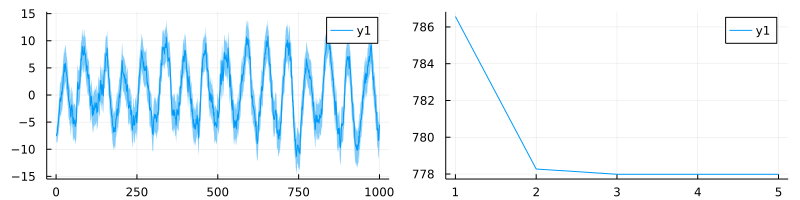

In [29]:
@time qxt, qτ, engine = testme(from(static))

p1 = plot(mean.(qxt), ribbon = std.(qxt))
p2 = plot(getvalues(engine.fe_actor))

plot(p1, p2, size = (800, 200))

In [193]:
using BenchmarkTools

In [194]:
@benchmark testme(from($static))

BenchmarkTools.Trial: 66 samples with 1 evaluation.
 Range (min … max):  54.996 ms … 114.452 ms  ┊ GC (min … max): 0.00% … 26.12%
 Time  (median):     71.419 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   76.473 ms ±  14.659 ms  ┊ GC (mean ± σ):  7.40% ± 11.65%

             ▂  █       ▄                                       
  ▄▁▄▄▁▄▆▄█▄▄██▆█▆▄▆▆█▄▁█▄▄▁▁▄▁▄▁▁▁▁▄▁▄▄▄▁▄▁█▁▁▄▁▄▁▆▆▁▄▁▁▁▄▁▁▄ ▁
  55 ms           Histogram: frequency by time          110 ms <

 Memory estimate: 34.47 MiB, allocs estimate: 824297.

In [124]:
plot_callback = (posteriors) -> begin
    IJulia.clear_output(true)

    p = plot(mean.(posteriors), ribbon = var.(posteriors), label = "Estimation")
    p = plot!(gethistory(process), label = "Real states")    
    p = scatter!(getobservations(process), ms = 2, label = "Observations")
    p = plot(p, size = (1000, 400), legend = :bottomright)
        
    display(p)
end

#127 (generic function with 1 method)